# Introduction

🕌  In this notebook, I demonstrate the process of building a deep learning model to classify images of popular mosques around the world. The steps involved include data exploration, data preprocessing, model training, evaluation, and prediction.

![Image](https://th.bing.com/th/id/R.3bc66ac5fbdd87565311a9ab21c6d241?rik=kE0151W4vtv8ug&pid=ImgRaw&r=0)

Let's get started!

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import shutil
from shutil import copytree, rmtree
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

2024-02-08 04:04:44.382856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 04:04:44.382951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 04:04:44.562070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Exploration

🔍 I begin by exploring the dataset to understand its structure and distribution. This involves counting the number of images in each class (mosque) and visualizing some random images from each class.

In [2]:
# Set up data directory
data_dir = r'/kaggle/input/popular-mosques-in-the-world'

# Get list of classes (mosques)
classes = os.listdir(data_dir)

# Display the number of images in each class
for mosque in classes:
    num_images = len(os.listdir(os.path.join(data_dir, mosque)))
    print(f"Number of images in class '{mosque}': {num_images}")

Number of images in class 'Mosques_Images': 6


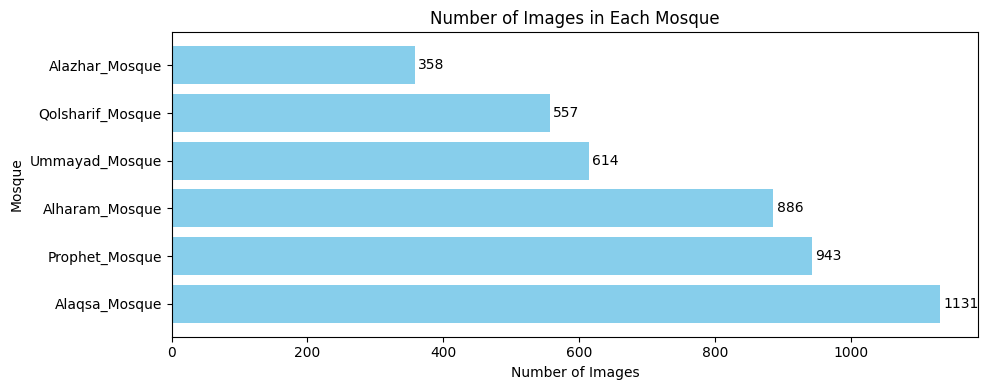

In [3]:
# Set up data directory
data_dir = r'/kaggle/input/popular-mosques-in-the-world/Mosques_Images'

# Get list of classes (mosques)
classes = os.listdir(data_dir)

# Create lists to store mosque names and corresponding image counts
mosque_names = []
image_counts = []

# Get the number of images in each class (mosque) and select three random images
for i, mosque in enumerate(classes):
    num_images = len(os.listdir(os.path.join(data_dir, mosque)))
    mosque_names.append(mosque)
    image_counts.append(num_images)

# Sort mosque names and image counts by the number of images
mosque_names_sorted, image_counts_sorted = zip(*sorted(zip(mosque_names, image_counts), key=lambda x: x[1]))

# Create the horizontal bar plot
plt.figure(figsize=(10, 4))
plt.barh(mosque_names_sorted, image_counts_sorted, color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Mosque')
plt.title('Number of Images in Each Mosque')
plt.gca().invert_yaxis()  # Invert y-axis to display the mosque names from top to bottom

# Add data labels to the bars
for i, count in enumerate(image_counts_sorted):
    plt.text(count+5, i, str(count), ha='left', va='center')

plt.tight_layout()
plt.show()

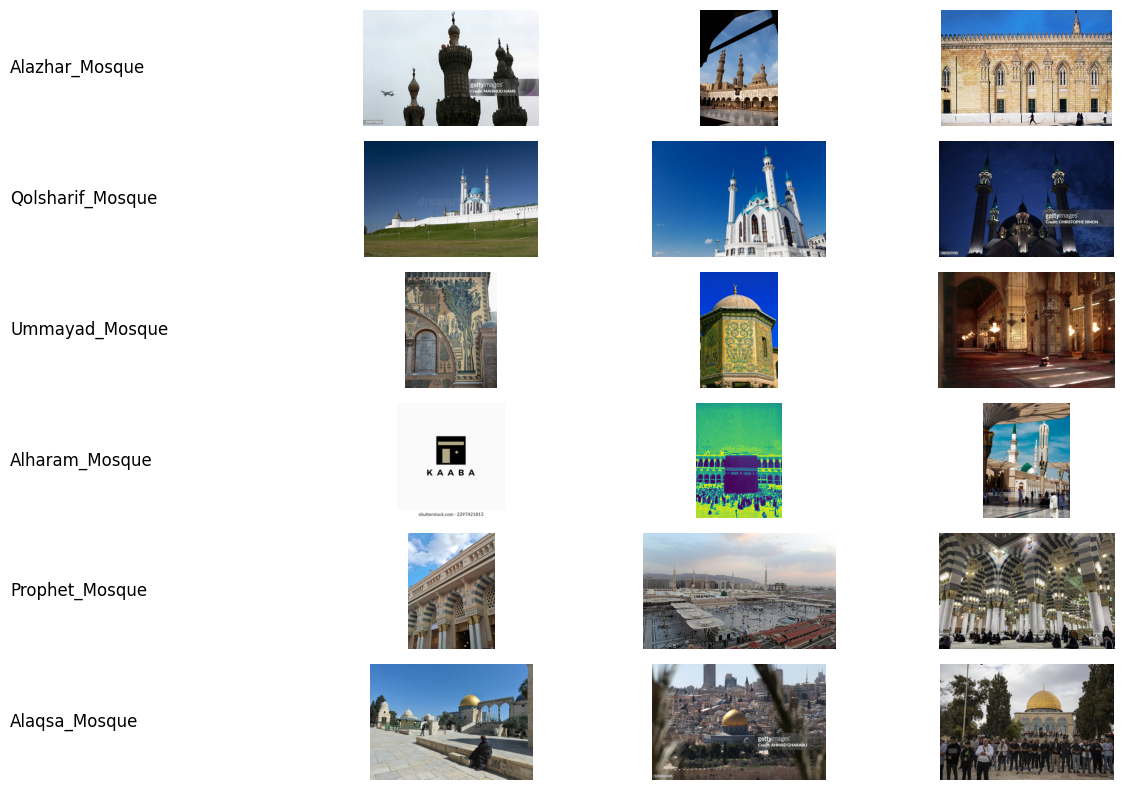

In [4]:
# Display three random images from each class (mosque)
fig, axes = plt.subplots(len(classes), 4, figsize=(12, 8))
for i, mosque in enumerate(mosque_names_sorted):
    # Display mosque name
    axes[i, 0].text(0, 0.5, mosque, fontsize=12, verticalalignment='center')
    axes[i, 0].axis('off')
    
    # Select three random images
    image_files = os.listdir(os.path.join(data_dir, mosque))
    random.shuffle(image_files)
    for j, image_file in enumerate(image_files[:3]):
        img = mpimg.imread(os.path.join(data_dir, mosque, image_file))
        axes[i, j+1].imshow(img)
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing

🛠️ Next, I preprocess the data for model training. This includes augmenting the images to increase the size of the dataset and splitting it into training, validation, and test sets.

In [5]:
# Set up data directories
input_data_dir = '/kaggle/input/popular-mosques-in-the-world/Mosques_Images'
working_data_dir = '/kaggle/working/Mosques_Images'

# Get list of classes (mosques)
classes = os.listdir(input_data_dir)

# Copy folders from input directory to working directory
for mosque in classes:
    input_mosque_dir = os.path.join(input_data_dir, mosque)
    working_mosque_dir = os.path.join(working_data_dir, mosque)
    copytree(input_mosque_dir, working_mosque_dir)

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the target number of images after augmentation
target_num_images = 1500

# Iterate through each class (mosque)
for mosque in classes:
    images_dir = os.path.join(working_data_dir, mosque)
    num_images = len(os.listdir(images_dir))
    
    # Calculate the number of augmented images to generate for each original image
    num_augmented_images_per_original = max(0, target_num_images // num_images - 1)
    
    # Generate augmented images directly in the working directory
    for img_name in os.listdir(images_dir):
        img_path = os.path.join(images_dir, img_name)
        img = load_img(img_path)  # Load image
        x = img_to_array(img)  # Convert image to array
        x = x.reshape((1,) + x.shape)  # Reshape image for flow method
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=images_dir, save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= num_augmented_images_per_original:  # Number of augmented images per original image
                break  # Break loop if target number of images reached

print('\n***** Data Augmentation Completed Successfully *****\n')


***** Data Augmentation Completed Successfully *****



In [6]:
# Set up data directory
data_dir = r'/kaggle/working/Mosques_Images'

# Get list of classes (mosques)
classes = os.listdir(data_dir)

# Display the number of images in each class
for mosque in classes:
    num_images = len(os.listdir(os.path.join(data_dir, mosque)))
    print(f"Number of images in class '{mosque}': {num_images}")

Number of images in class 'Qolsharif_Mosque': 1096
Number of images in class 'Alazhar_Mosque': 1372
Number of images in class 'Alharam_Mosque': 1738
Number of images in class 'Alaqsa_Mosque': 2202
Number of images in class 'Ummayad_Mosque': 1214
Number of images in class 'Prophet_Mosque': 1851


In [7]:
# Set up data directories (relative paths)
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

# Define splitting ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Iterate through each class (mosque)
for mosque in classes:
    images_dir = os.path.join(data_dir, mosque)
    images = [os.path.join(images_dir, img) for img in os.listdir(images_dir)]
    
    # Split images into train, validation, and test sets
    train_images, test_images = train_test_split(images, test_size=test_ratio, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)
    
    # Create directories for train, validation, and test sets
    train_dir_mosque = os.path.join(train_dir, mosque)
    val_dir_mosque = os.path.join(val_dir, mosque)
    test_dir_mosque = os.path.join(test_dir, mosque)
    
    os.makedirs(train_dir_mosque, exist_ok=True)
    os.makedirs(val_dir_mosque, exist_ok=True)
    os.makedirs(test_dir_mosque, exist_ok=True)
    
    # Copy images to their respective directories
    for img in train_images:
        shutil.copy(img, train_dir_mosque)
    for img in val_images:
        shutil.copy(img, val_dir_mosque)
    for img in test_images:
        shutil.copy(img, test_dir_mosque)

print('\n***** Splitting the Data Completed Successfully *****\n')


***** Splitting the Data Completed Successfully *****



## Model Training

🚀 I build a convolutional neural network (CNN) using the MobileNetV2 architecture pre-trained on ImageNet. I freeze the base layers of the model and fine-tune the top layers for mosque classification. The model is trained using the training and validation data, with early stopping to prevent overfitting.

In [8]:
# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6626 images belonging to 6 classes.
Found 1423 images belonging to 6 classes.
Found 1424 images belonging to 6 classes.


In [9]:
# Build the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]  # Include early stopping callback
)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30


I0000 00:00:1707365478.930588     154 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/208 [==============================] - 112s 510ms/step - loss: 0.7928 - accuracy: 0.7223 - val_loss: 0.5493 - val_accuracy: 0.8089
Epoch 2/30
208/208 [==============================] - 103s 493ms/step - loss: 0.5200 - accuracy: 0.8219 - val_loss: 0.4241 - val_accuracy: 0.8482
Epoch 3/30
208/208 [==============================] - 104s 502ms/step - loss: 0.4263 - accuracy: 0.8495 - val_loss: 0.4696 - val_accuracy: 0.8370
Epoch 4/30
208/208 [==============================] - 104s 502ms/step - loss: 0.3856 - accuracy: 0.8692 - val_loss: 0.4102 - val_accuracy: 0.8623
Epoch 5/30
208/208 [==============================] - 105s 503ms/step - loss: 0.3505 - accuracy: 0.8765 - val_loss: 0.3211 - val_accuracy: 0.8848
Epoch 6/30
208/208 [==============================] - 103s 493ms/step - loss: 0.3174 - accuracy: 0.8873 - val_loss: 0.3558 - val_accuracy: 0.8700
Epoch 7/30
208/208 [==============================] - 104s 499ms/step - loss: 0.2912 - accuracy: 0.8972 - val_loss: 0.2765 - val_accura

## Model Evaluation

📊 I evaluate the trained model on the test set to assess its performance in terms of loss and accuracy.

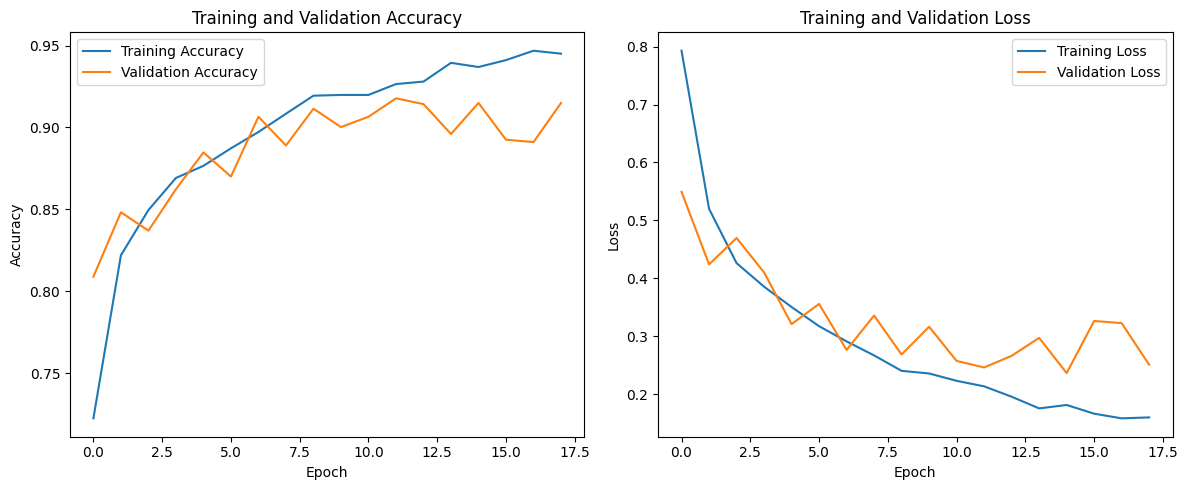

In [10]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Training and Validation Accuracy')

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Training and Validation Loss')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


In [11]:
# Save the model
model.save('mosques_model.keras')

In [12]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('mosques_model.keras')

## Data Prediction

🔮I demonstrate how to use the trained model to make predictions on new images. Random images from the test set are selected, and their actual and predicted labels are displayed.

1/1 [==============================] - 1s 856ms/step


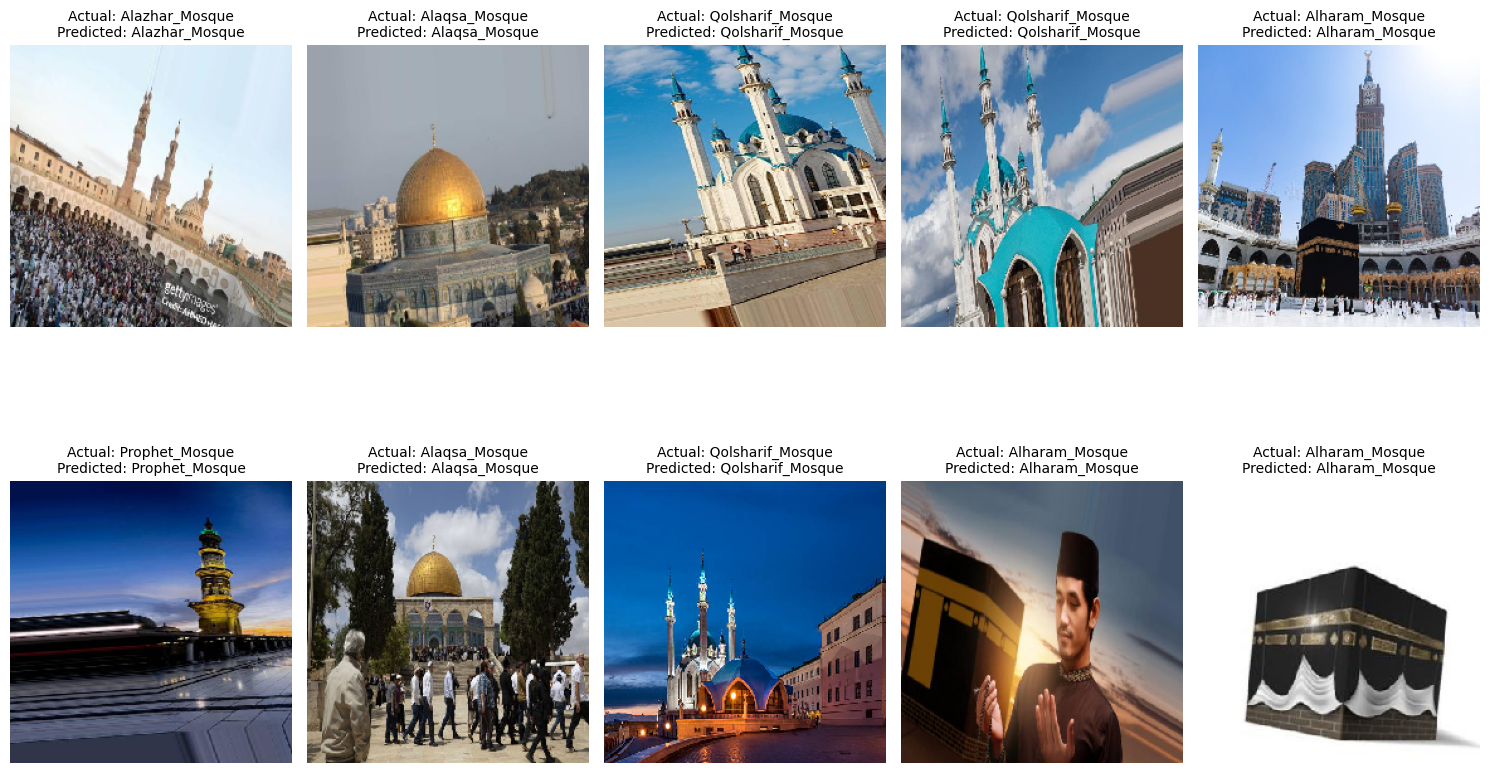

In [14]:
import random

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Get a batch of images and labels from the test generator
test_images, test_labels = test_generator.next()

# Predictions for the batch
predictions = model.predict(test_images)

# Randomly select 10 indices
random_indices = random.sample(range(len(test_images)), 10)

# Plot the images with actual and predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx])
    plt.axis('off')
    actual_label = class_labels[np.argmax(test_labels[idx])]
    predicted_label = class_labels[np.argmax(predictions[idx])]
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
plt.tight_layout()
plt.show()

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

def predict_and_display(image_path, model_path):
    try:
        # Load and resize the image
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize pixel values
        plt.imshow(img_array)
        plt.axis('off')
        plt.show()

        # Load the model
        model = load_model(model_path)

        # Preprocess the image for prediction
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class = classes[predicted_class_index]
        print(f"Predicted Class: {predicted_class}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [18]:
model_path = '/kaggle/working/mosques_model.keras'

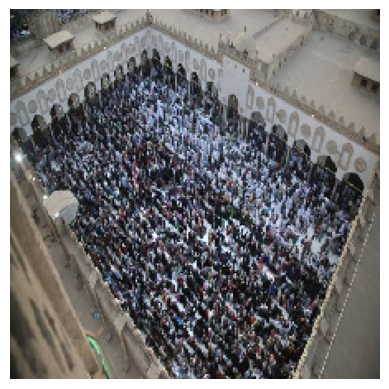

1/1 [==============================] - 1s 809ms/step
Predicted Class: Alazhar_Mosque


In [29]:
image_path2 = '/kaggle/input/mosques-test-images/2.jpg'
predict_and_display(image_path2, model_path)

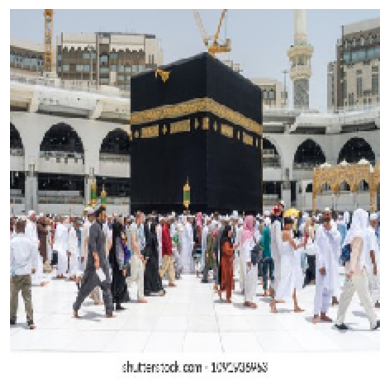

1/1 [==============================] - 1s 884ms/step
Predicted Class: Alharam_Mosque


In [30]:
image_path3 = '/kaggle/input/mosques-test-images/3.jpg' 
predict_and_display(image_path3, model_path)

# Conclusion

🎉 In conclusion, this notebook provides a comprehensive example of building and training a deep learning model for image classification. It highlights the importance of data exploration, preprocessing, model selection, and evaluation in the machine learning pipeline.

# Made by: Abdelrahman Eldaba 👨‍💻

Check out my portfolio [Here](https://www.linkedin.com/posts/abdelrahman-eldaba-739805192_datascience-dataanalysis-webscraping-activity-7156428468711219201-gtWA/) 🌟

Connect with me on [LinkedIn](https://www.linkedin.com/in/abdelrahman-eldaba-739805192/) 🌐

Look at my [GitHub](https://github.com/Abdelrahman47-code) 🚀